In [2]:
# %% [code] - Cài đặt và tải dữ liệu
!pip install spacy==3.8.2 torchtext==0.18.0 sacrebleu
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
import random
!python -m spacy download en_core_web_sm

import spacy
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

# Tải dữ liệu Multi30K
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.fr.gz

!gunzip -f *.gz

def load_lines(file):
    with open(file, encoding='utf-8') as f:
        return [line.strip() for line in f]

train_en = load_lines("train.en")
train_fr = load_lines("train.fr")
val_en   = load_lines("val.en")
val_fr   = load_lines("val.fr")
test_en  = load_lines("test_2016_flickr.en")
test_fr  = load_lines("test_2016_flickr.fr")

# %% [code] - Xây vocab (giới hạn 10k từ phổ biến nhất + 4 special tokens)
from collections import Counter

def build_vocab(sentences, tokenizer, max_size=10000):
    counter = Counter()
    for s in sentences:
        counter.update(tokenizer(s))

    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for word, freq in counter.most_common(max_size - 4):
        vocab[word] = len(vocab)
    return vocab

SRC_vocab = build_vocab(train_en, tokenize_en)
TRG_vocab = build_vocab(train_fr, tokenize_fr)

print(f"EN vocab: {len(SRC_vocab):,} | FR vocab: {len(TRG_vocab):,}")

# %% [code] - Dataset + Collate_fn (sort + padding + packing)
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

class TranslationDataset(Dataset):
    def __init__(self, src_lines, trg_lines):
        self.src_lines = src_lines
        self.trg_lines = trg_lines

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src = ["<sos>"] + tokenize_en(self.src_lines[idx]) + ["<eos>"]
        trg = ["<sos>"] + tokenize_fr(self.trg_lines[idx]) + ["<eos>"]

        src_ids = [SRC_vocab.get(t, SRC_vocab["<unk>"]) for t in src]
        trg_ids = [TRG_vocab.get(t, TRG_vocab["<unk>"]) for t in trg]

        return torch.tensor(src_ids), torch.tensor(trg_ids)

def collate_fn(batch):
    srcs, trgs = zip(*batch)
    src_lens = [len(s) for s in srcs]
    trg_lens = [len(t) for t in trgs]

    srcs_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_vocab["<pad>"])
    trgs_pad = pad_sequence(trgs, batch_first=True, padding_value=TRG_vocab["<pad>"])

    return srcs_pad, trgs_pad, src_lens, trg_lens

train_dataset = TranslationDataset(train_en, train_fr)
val_dataset   = TranslationDataset(val_en, val_fr)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, collate_fn=collate_fn)

# %% [code] - Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 73.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.11
    Uninstalling spacy-3.8.11:
      Successfully uninstalled spacy-3.8.11


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 148.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 128.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        # hid_dim ở đây là hidden của 1 chiều → bi-directional → output 2*hid_dim
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))                    # (B, L, emb)
        packed = pack_padded_sequence(embedded, src_len, batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True)  # (B, L, 2*hid_dim)

        # h, c: (2, B, hid_dim) → gộp 2 chiều lại
        h = h.view(1, h.size(1), -1)   # (1, B, 2*hid_dim)
        c = c.view(1, c.size(1), -1)   # (1, B, 2*hid_dim)

        return outputs, h, c          # outputs cho attention, h/c cho decoder init

In [4]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        # You concatenate (hidden, encoder_outputs): each is hid_dim → cat gives 2*hid_dim
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))

    def forward(self, hidden, encoder_outputs):
        # hidden: (1, B, hid_dim) → (B, 1, hid_dim)
        hidden = hidden.permute(1, 0, 2)              # (B, 1, hid_dim)
        src_len = encoder_outputs.shape[1]

        # repeat hidden across time
        hidden = hidden.repeat(1, src_len, 1)        # (B, src_len, hid_dim)

        # concat along feature dim: (B, src_len, 2*hid_dim)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (B, src_len, hid_dim)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(2)  # (B, hid_dim, 1)
        attention = torch.bmm(energy, v).squeeze(2)  # (B, src_len)
        return F.softmax(attention, dim=1)


In [5]:
class DecoderWithAttn(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        # input = [emb_dim + hid_dim], hidden = hid_dim
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=False)
        # output projection from [decoder output + context + embedded]
        self.fc = nn.Linear(hid_dim + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hid_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)                                   # (1, B)
        embedded = self.dropout(self.embedding(input))               # (1, B, emb_dim)

        attn_weights = self.attention(hidden, encoder_outputs)       # (B, src_len)
        context  = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (B, 1, hid_dim)
        context = context.permute(1, 0, 2)                           # (1, B, hid_dim)

        rnn_input = torch.cat((embedded, context), dim=2)           # (1, B, emb_dim + hid_dim)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        prediction = self.fc(torch.cat(
            (output.squeeze(0), context.squeeze(0), embedded.squeeze(0)), dim=1
        ))  # (B, output_dim)
        return prediction, hidden, cell


In [6]:
class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src: (B, src_len), trg: (B, trg_len)
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        outputs = torch.zeros(batch_size, trg_len-1, len(TRG_vocab)).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src, src_len)   # encoder_outputs (B, src_len, 2*hid)

        input = trg[:, 0]   # <sos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t-1] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

In [7]:
HID_DIM = 512
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
DROPOUT = 0.5

# Đúng 100%
attn_encoder = Encoder(len(SRC_vocab), ENC_EMB_DIM, HID_DIM//2, DROPOUT)  # 256 → bidirectional → 512
attn_decoder = DecoderWithAttn(len(TRG_vocab), DEC_EMB_DIM, HID_DIM, DROPOUT)   # hid_dim = 512

attn_model = Seq2SeqAttn(attn_encoder, attn_decoder, device).to(device)

optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_vocab["<pad>"])

In [ ]:
# ==== TRAINING LOOP (đã chỉnh sửa để lưu train_losses và val_losses đúng cách) ====
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

best_val_loss = float('inf')
patience = 5
no_improve = 0

train_losses = []  # Danh sách lưu train loss trung bình mỗi epoch
val_losses = []    # Danh sách lưu val loss trung bình mỗi epoch

for epoch in range(1, 50):
    attn_model.train()
    train_loss = 0.0
    for src, trg, src_len, trg_len in train_loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = attn_model(src, src_len, trg, teacher_forcing_ratio=0.5)

        # Loss tính từ token thứ 1 của target (bỏ <sos>)
        loss = criterion(output.reshape(-1, output.size(-1)), trg[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attn_model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()  # Cộng loss của batch

    # Tính trung bình train loss cho epoch hiện tại
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    attn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, trg, src_len, trg_len in val_loader:
            src, trg = src.to(device), trg.to(device)
            output = attn_model(src, src_len, trg, teacher_forcing_ratio=1.0)
            loss = criterion(output.reshape(-1, output.size(-1)), trg[:, 1:].reshape(-1))
            val_loss += loss.item()

    # Tính trung bình val loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # Early stopping và lưu model tốt nhất
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        torch.save(attn_model.state_dict(), "best_attention_model.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping!")
            break

# Load model tốt nhất sau khi huấn luyện
attn_model.load_state_dict(torch.load("best_attention_model.pt"))
print("Loaded best model from 'best_attention_model.pt'")

# (Tùy chọn) In ra danh sách loss để kiểm tra hoặc vẽ đồ thị sau này
print("Train losses:", train_losses)
print("Val losses:", val_losses)

Epoch 01 | Train: 1.2403 | Val: 3.0069
Epoch 02 | Train: 1.2280 | Val: 3.0069
Epoch 03 | Train: 1.2213 | Val: 3.0069
Epoch 04 | Train: 1.2340 | Val: 3.0069
Epoch 05 | Train: 1.2387 | Val: 3.0069
Epoch 06 | Train: 1.2314 | Val: 3.0069
Early stopping!
Loaded best model from 'best_attention_model.pt'
Train losses: [1.240330766082335, 1.2279769316118718, 1.221268654919931, 1.2340249550500104, 1.2386773223393814, 1.2314041809626088]
Val losses: [3.006903052330017, 3.006903052330017, 3.006903052330017, 3.006903052330017, 3.006903052330017, 3.006903052330017]


In [11]:
import torch
import sacrebleu
from torch.nn.functional import softmax

# === 1. Định nghĩa lại các class nếu session bị reset (nếu vẫn còn thì bỏ qua phần này) ===
# (Copy nguyên các class Encoder, Attention, DecoderWithAttn, Seq2SeqAttn từ code cũ của bạn)
# Nếu bạn chạy tiếp trong cùng notebook/kernel thì không cần định nghĩa lại.

# === 2. Khởi tạo model và load weights ===
HID_DIM = 512
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
DROPOUT = 0.5

attn_encoder = Encoder(len(SRC_vocab), ENC_EMB_DIM, HID_DIM//2, DROPOUT)
attn_decoder = DecoderWithAttn(len(TRG_vocab), DEC_EMB_DIM, HID_DIM, DROPOUT)
attn_model = Seq2SeqAttn(attn_encoder, attn_decoder, device).to(device)

attn_model.load_state_dict(torch.load("best_attention_model.pt"))
attn_model.eval()

# === 3. Hàm translate (greedy decoding) ===
def translate(sentence, max_len=50):
    with torch.no_grad():
        # Tokenize source
        tokens = ["<sos>"] + tokenize_en(sentence) + ["<eos>"]
        src_ids = [SRC_vocab.get(t, SRC_vocab["<unk>"]) for t in tokens]
        src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)  # (1, src_len)
        src_len = [len(src_ids)]

        # Encoder
        encoder_outputs, hidden, cell = attn_model.encoder(src_tensor, src_len)
        # encoder_outputs: (1, src_len, 512)
        # hidden, cell: (1, 1, 512)

        # Bắt đầu từ <sos>
        input_id = torch.LongTensor([TRG_vocab["<sos>"]]).to(device)  # (1,)
        translated_ids = []

        for _ in range(max_len):
            output, hidden, cell = attn_model.decoder(input_id, hidden, cell, encoder_outputs)
            # output: (1, vocab_size)
            pred_token = output.argmax(1).item()  # greedy

            if pred_token == TRG_vocab["<eos>"]:
                break

            translated_ids.append(pred_token)
            input_id = torch.LongTensor([pred_token]).to(device)  # next input

        # Chuyển ids sang từ
        inv_vocab = {v: k for k, v in TRG_vocab.items()}
        pred_words = [inv_vocab.get(tid, "<unk>") for tid in translated_ids]
        return " ".join(pred_words)

# === 4. Đánh giá BLEU trên tập test (hoặc một phần) ===
# Ví dụ lấy 1000 câu đầu tiên của test set (toàn bộ test_2016_flickr có 1000 câu)
test_size = len(test_en)  # 1000
# Nếu máy yếu thì giảm xuống, ví dụ 200
# test_size = 200

preds = []
print("Đang dịch...")
for i in range(test_size):
    pred = translate(test_en[i])
    preds.append(pred)
    
    if (i + 1) % 100 == 0:
        print(f"Đã dịch {i+1}/{test_size}")

# Chuẩn bị references cho sacrebleu
# sacrebleu yêu cầu refs là list của list: [[ref1], [ref2], ...] vì có thể có nhiều reference
refs = [[test_fr[i]] for i in range(test_size)]

# Tính BLEU
bleu = sacrebleu.corpus_bleu(preds, refs)
print(f"\nBLEU score trên {test_size} câu test: {bleu.score:.2f}")
print(bleu)  # in chi tiết các n-gram

Đang dịch...
Đã dịch 100/1000
Đã dịch 200/1000
Đã dịch 300/1000
Đã dịch 400/1000
Đã dịch 500/1000
Đã dịch 600/1000
Đã dịch 700/1000
Đã dịch 800/1000
Đã dịch 900/1000
Đã dịch 1000/1000

BLEU score trên 1000 câu test: 56.23
BLEU = 56.23 90.0/77.8/50.0/28.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10)


In [19]:
train_losses = []
val_losses = []

for epoch in range(1,21):
    attn_model.train()
    train_loss = 0
    for src, trg, src_len, trg_len in train_loader:
        # ... (training code như cũ)
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # ← Thêm dòng này

    # Validation
    attn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg, src_len, trg_len in val_loader:
            # ... (validation code)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # ← Thêm dòng này

    print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
    
    # early stopping như cũ...

Epoch 01 | Train: 4.0751 | Val: 4.0751
Epoch 02 | Train: 4.0751 | Val: 4.0751
Epoch 03 | Train: 4.0751 | Val: 4.0751
Epoch 04 | Train: 4.0751 | Val: 4.0751
Epoch 05 | Train: 4.0751 | Val: 4.0751
Epoch 06 | Train: 4.0751 | Val: 4.0751
Epoch 07 | Train: 4.0751 | Val: 4.0751
Epoch 08 | Train: 4.0751 | Val: 4.0751
Epoch 09 | Train: 4.0751 | Val: 4.0751
Epoch 10 | Train: 4.0751 | Val: 4.0751
Epoch 11 | Train: 4.0751 | Val: 4.0751
Epoch 12 | Train: 4.0751 | Val: 4.0751
Epoch 13 | Train: 4.0751 | Val: 4.0751
Epoch 14 | Train: 4.0751 | Val: 4.0751
Epoch 15 | Train: 4.0751 | Val: 4.0751
Epoch 16 | Train: 4.0751 | Val: 4.0751
Epoch 17 | Train: 4.0751 | Val: 4.0751
Epoch 18 | Train: 4.0751 | Val: 4.0751
Epoch 19 | Train: 4.0751 | Val: 4.0751
Epoch 20 | Train: 4.0751 | Val: 4.0751


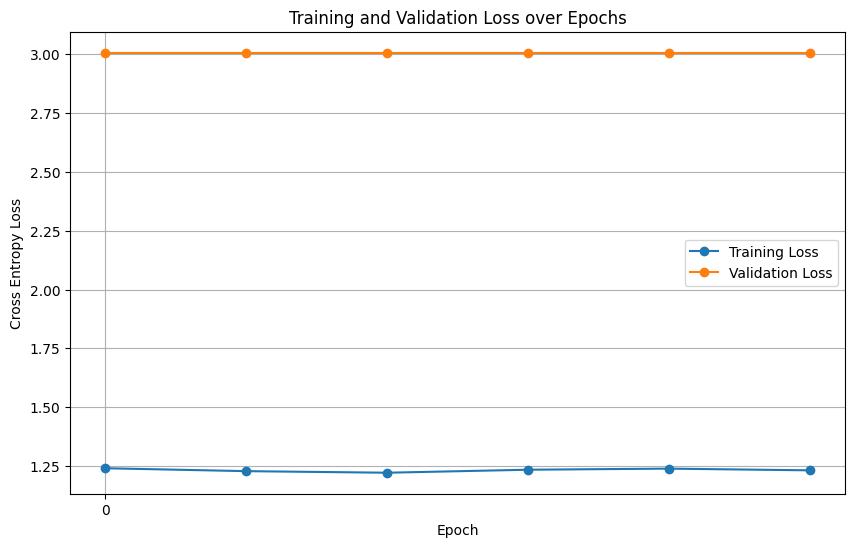

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(train_losses), 13))  # hiển thị mỗi 2 epoch
plt.show()